In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(dpi=80, dpi_save=300)

scanpy==1.4 anndata==0.6.18 numpy==1.16.1 scipy==1.2.0 pandas==0.23.4 scikit-learn==0.20.2 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [3]:
adata = sc.read_h5ad("../../DMCA.h5ad")
adata

AnnData object with n_obs × n_vars = 333778 × 34947 
    obs: 'Cell', 'Cluster_id', 'batch', 'P', 'Tissue', 'OldCellType', 'CellType'

In [4]:
# anno = pd.read_csv("../louvain_MCA.csv")
# df = pd.read_csv("../Anno_MCA_all.csv")
# anno = anno.merge(df, how='left', left_on='CellType', right_on='OldCellType')
# anno['batch'] = anno['Cell'].map(lambda x: x.split('.')[0])
# anno['P'] = anno['batch'].map(lambda x: x.split('_')[-1])
# anno['Tissue'] = anno['batch'].map(lambda x: x.split('_')[0])
# anno.index = anno['Cell']
# anno = anno.drop('CellType', axis=1)
# anno = anno.rename(columns={'NewCellType':'CellType'})
# adata.obs = anno.loc[adata.obs.index,:]
# adata.obs.head()
# anno.to_csv("../Anno_MCA.csv")
# adata.write("../DMCA.h5ad")

In [4]:
np.unique(adata.obs.Tissue)

array(['AdultAdrenalGland', 'AdultBladder', 'AdultBoneMarrow',
       'AdultBoneMarrowcKit', 'AdultBrain', 'AdultMammaryGland',
       'AdultOmentum', 'AdultPleura', 'AdultProstate', 'AdultStomach',
       'FetalBrain', 'FetalEmbryonicMesenchyme',
       'FetalEmbryonicStemCells', 'FetalFemaleGonad', 'FetalHeart',
       'FetalIntestine', 'FetalKidney', 'FetalLiver', 'FetalLung',
       'FetalMaleGonad', 'FetalPancreas', 'FetalStomach', 'Kidney',
       'Liver', 'Lung', 'Male', 'MammaryGland', 'MesenchymalStemCells',
       'MesenchymalStemCellsPrimary', 'Muscle', 'NeonatalCalvaria',
       'NeonatalHeart', 'NeonatalMuscle', 'NeonatalPancreas',
       'NeonatalRib', 'NeonatalSkin', 'NeontalBrain', 'Ovary', 'Pancreas',
       'PeripheralBlood', 'Placenta', 'SmallIntestine', 'Spleen',
       'Testis', 'Thymus', 'Uterus'], dtype=object)

In [8]:
adata = adata[adata.obs.Tissue.isin(['Kidney','FetalKidney']),]
adata

View of AnnData object with n_obs × n_vars = 14105 × 34947 
    obs: 'Cell', 'Cluster_id', 'batch', 'P', 'Tissue', 'OldCellType', 'CellType'

In [9]:
adata.var_names_make_unique()
adata

View of AnnData object with n_obs × n_vars = 14105 × 34947 
    obs: 'Cell', 'Cluster_id', 'batch', 'P', 'Tissue', 'OldCellType', 'CellType'

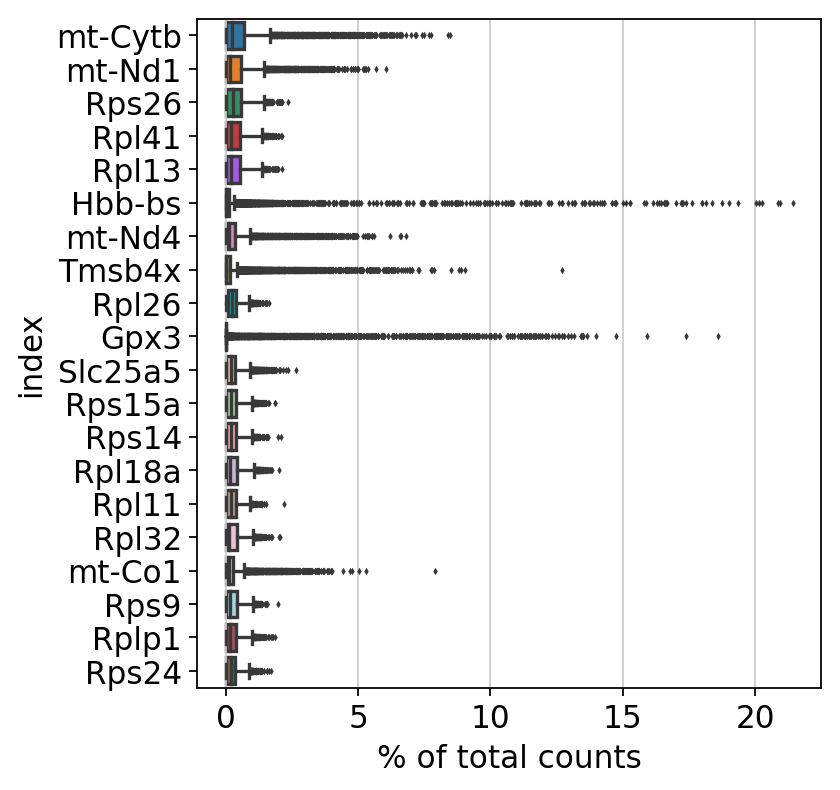

In [13]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [14]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [15]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)

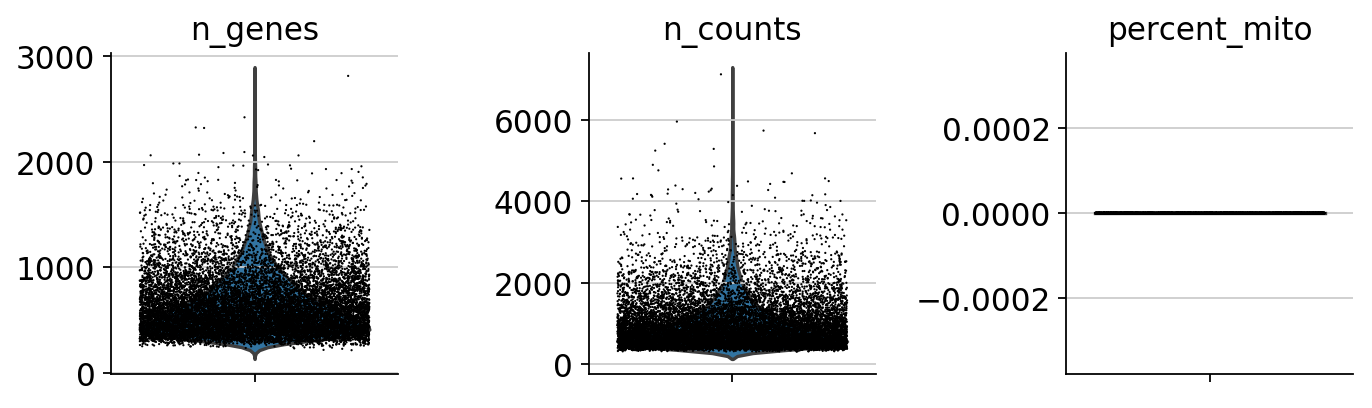

In [16]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

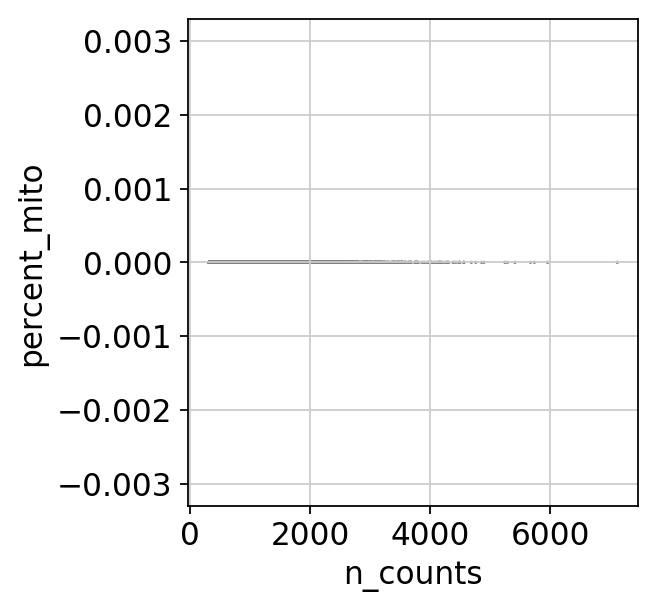

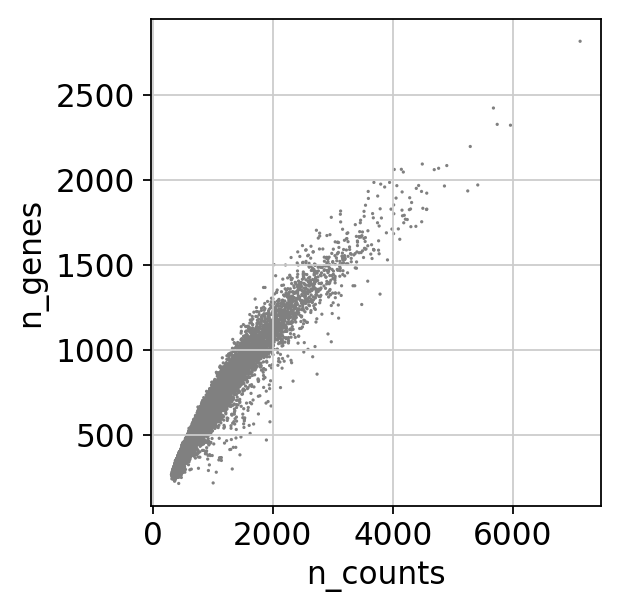

In [17]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [18]:
adata = adata[adata.obs.n_genes < 2500, :]
adata = adata[adata.obs.percent_mito < 0.05, :]
adata

View of AnnData object with n_obs × n_vars = 14104 × 17708 
    obs: 'Cell', 'Cluster_id', 'batch', 'P', 'Tissue', 'OldCellType', 'CellType', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'

In [19]:
adata

View of AnnData object with n_obs × n_vars = 14104 × 17708 
    obs: 'Cell', 'Cluster_id', 'batch', 'P', 'Tissue', 'OldCellType', 'CellType', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'

In [20]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

In [21]:
sc.pp.log1p(adata)

In [22]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


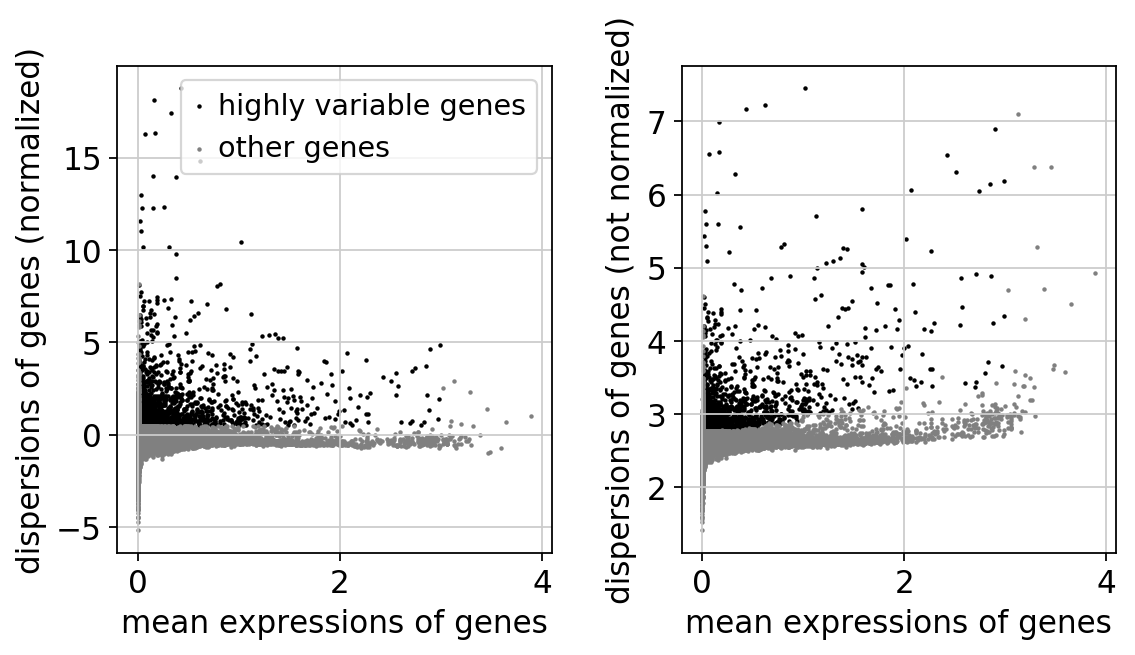

In [23]:
sc.pl.highly_variable_genes(adata)

In [24]:
adata = adata[:, adata.var.highly_variable]

In [25]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    finished (0:00:44.40)


In [26]:
adata

AnnData object with n_obs × n_vars = 14104 × 2237 
    obs: 'Cell', 'Cluster_id', 'batch', 'P', 'Tissue', 'OldCellType', 'CellType', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [84]:
adata_base = adata.copy()

In [85]:
adata_base

AnnData object with n_obs × n_vars = 14104 × 2237 
    obs: 'Cell', 'Cluster_id', 'batch', 'P', 'Tissue', 'OldCellType', 'CellType', 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    uns: 'CellType_colors', 'batch_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'

In [86]:
sc.pp.scale(adata_base, max_value=10)

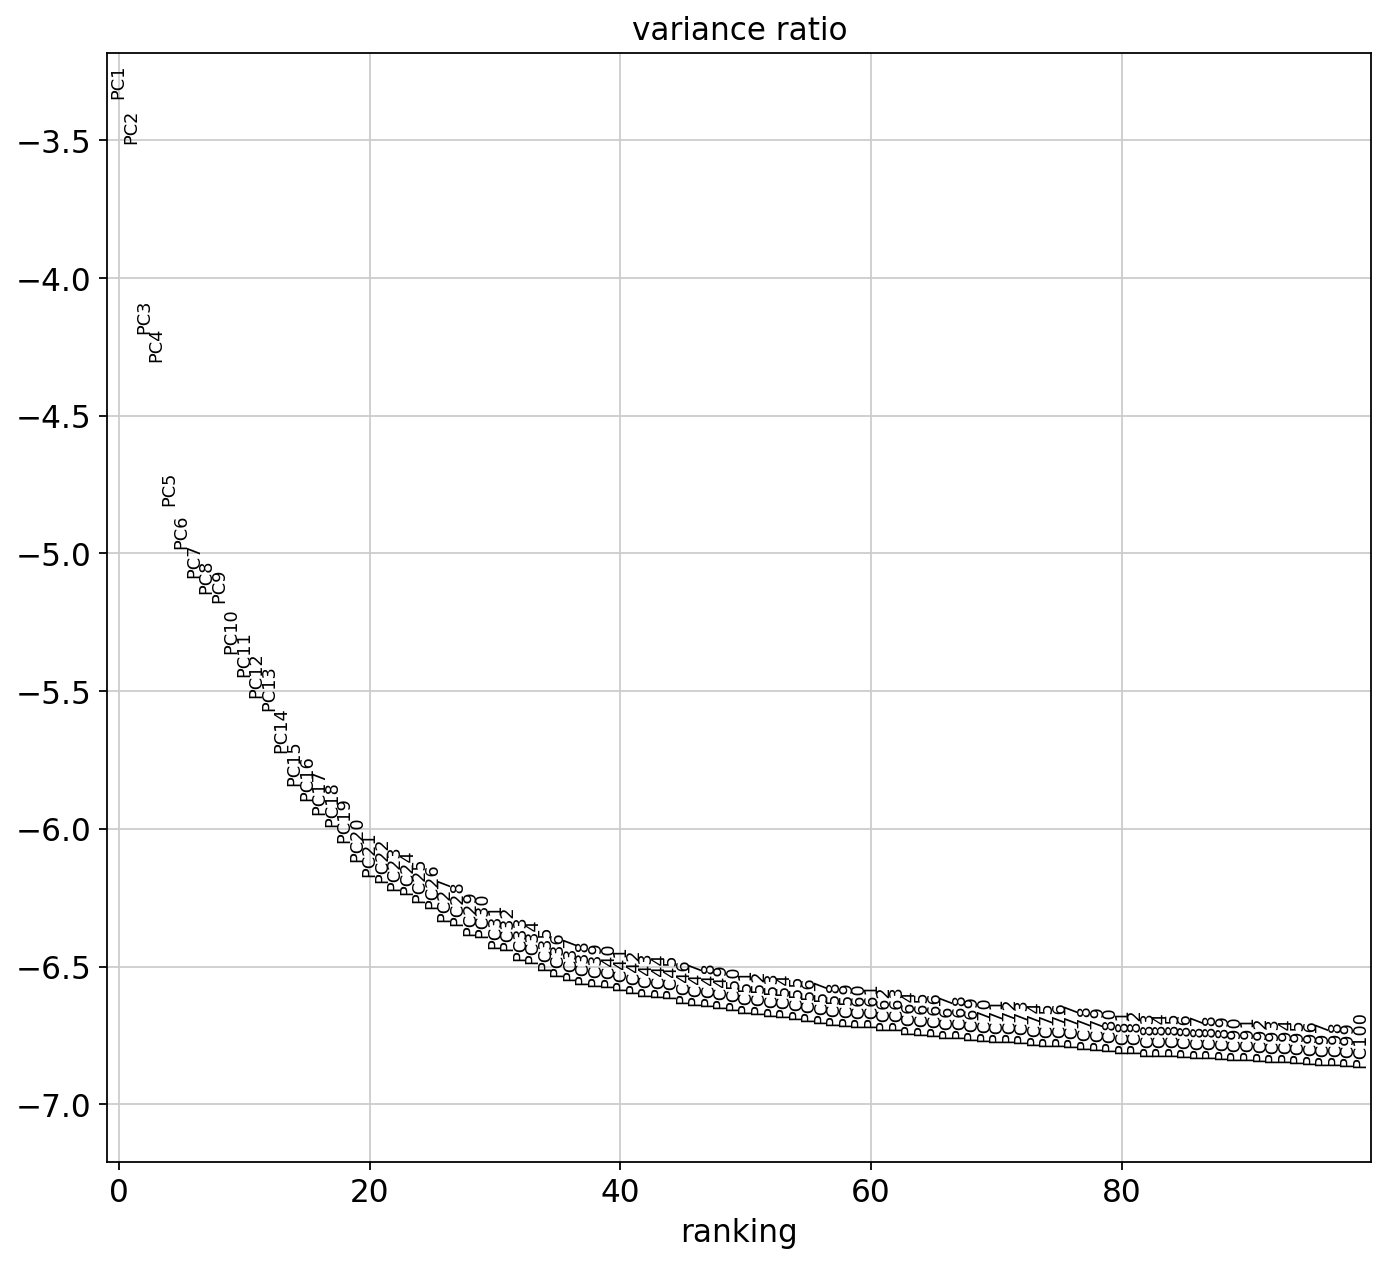

In [87]:
## PCA
sc.tl.pca(adata_base, n_comps=100, svd_solver='arpack')
# Pick nPC
sc.pl.pca_variance_ratio(adata_base, log=True, show=100, n_pcs=100)

In [88]:
#nPC=45
sc.pp.neighbors(adata_base, n_pcs=45, n_neighbors=15)

computing neighbors
    using 'X_pca' with n_pcs = 45
    finished (0:00:05.39) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


In [89]:
#run tSNE
sc.tl.tsne(adata_base, n_pcs=45, use_fast_tsne=True, n_jobs=20, perplexity=30)

computing tSNE
    using 'X_pca' with n_pcs = 45
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:01:22.63) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


In [90]:
sc.pl.tsne(adata_base, color=['batch'], size=10, save="_Batch_Baseline.pdf")
sc.pl.tsne(adata_base, color=['CellType'], size=10, save="_CellType_Baseline.pdf")

saving figure to file ./figures/tsne_Batch_Baseline.pdf
saving figure to file ./figures/tsne_CellType_Baseline.pdf


In [91]:
#res=0.6
sc.tl.louvain(adata_base, resolution=0.6)
sc.pl.tsne(adata_base, color='louvain', size=10, legend_loc='on data', legend_fontsize=8,save='_Cluster_Baseline.pdf')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:02.32) --> found 17 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
saving figure to file ./figures/tsne_Cluster_Baseline.pdf


In [92]:
adata_base.obs.to_csv("./cluster_Baseline.txt", index=False)

In [36]:
adata_reg = adata.copy()

In [37]:
%%time
sc.pp.regress_out(adata_reg, ['batch'])

regressing out ['batch']
    finished (0:00:58.23)
CPU times: user 13min 54s, sys: 14min 43s, total: 28min 37s
Wall time: 58.3 s


In [38]:
## scale the data
sc.pp.scale(adata_reg, max_value=10)

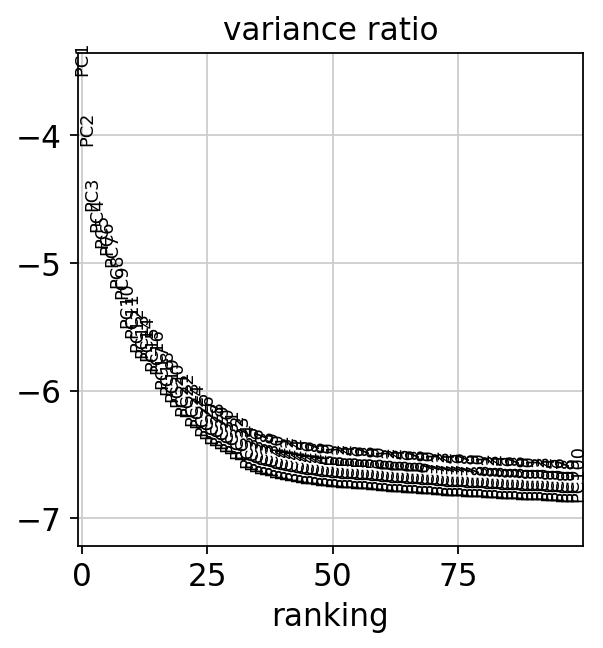

In [39]:
## PCA
sc.tl.pca(adata_reg,  n_comps=100, svd_solver='arpack')
# Pick nPC
sc.pl.pca_variance_ratio(adata_reg, log=True, show=100, n_pcs=100)

In [40]:
#nPC=45
sc.pp.neighbors(adata_reg, n_pcs=45, n_neighbors=15)

computing neighbors
    using 'X_pca' with n_pcs = 45
    finished (0:06:49.39) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


In [41]:
#run tSNE
sc.tl.tsne(adata_reg, n_pcs=45, use_fast_tsne=True, n_jobs=20, perplexity=30)

computing tSNE
    using 'X_pca' with n_pcs = 45
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:57.85) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


saving figure to file ./figures/tsne_Batch_reg.pdf


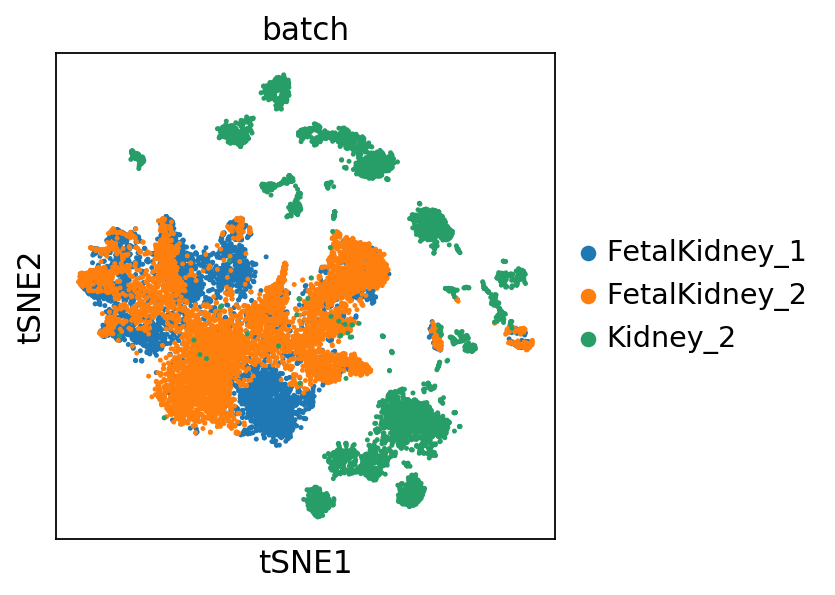

saving figure to file ./figures/tsne_CellType_reg.pdf


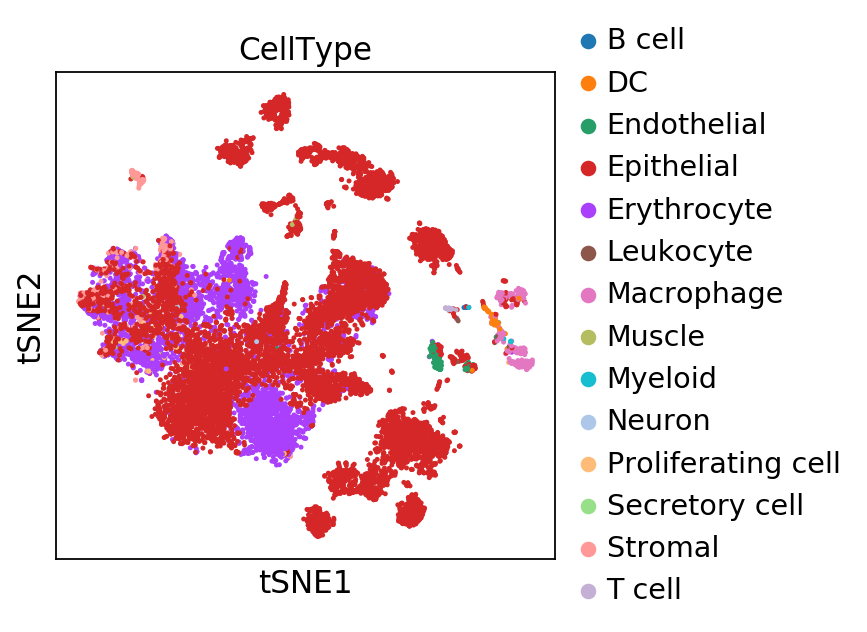

saving figure to file ./figures/tsne_CellType_reg_ondata.pdf


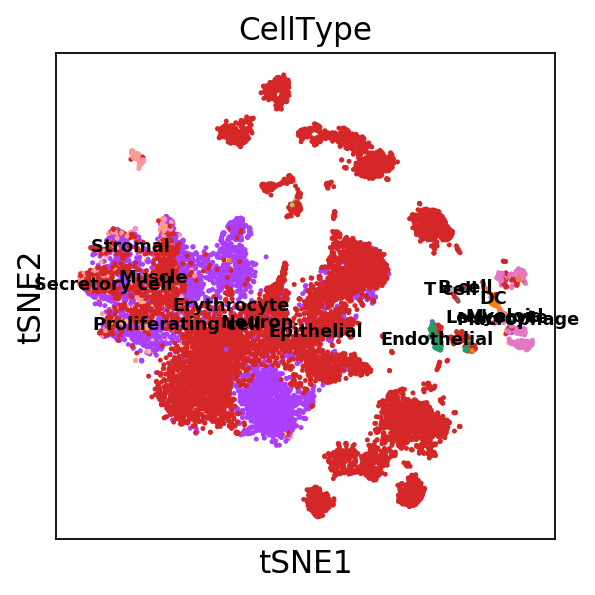

In [42]:
sc.pl.tsne(adata_reg, color=['batch'], size=20, save="_Batch_reg.pdf")
sc.pl.tsne(adata_reg, color=['CellType'], size=20, save="_CellType_reg.pdf")
sc.pl.tsne(adata_reg, color=['CellType'], size=20, legend_loc='on data', legend_fontsize=8, save="_CellType_reg_ondata.pdf")

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:01.73) --> found 19 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
saving figure to file ./figures/tsne_Cluster_reg.pdf


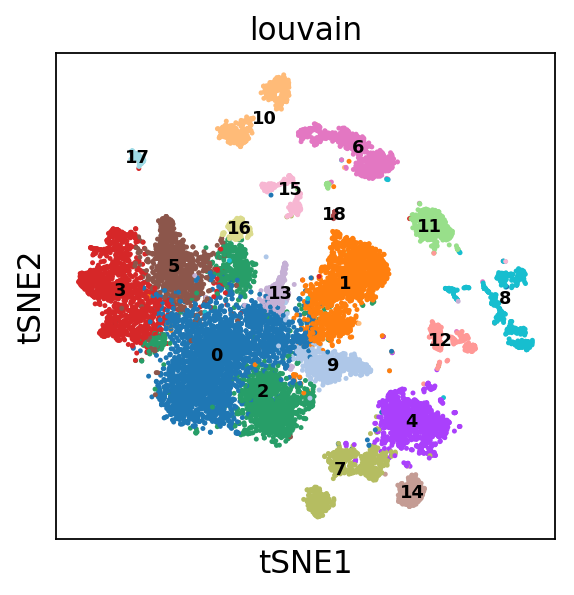

In [43]:
#res=0.6
sc.tl.louvain(adata_reg, resolution=0.6)
sc.pl.tsne(adata_reg, color='louvain',size=20,legend_loc='on data', legend_fontsize=8, save='_Cluster_reg.pdf')

In [44]:
adata_reg.obs.to_csv("./cluster_reg.txt", index=False)

In [45]:
adata_combat = adata.copy()

In [46]:
%%time
sc.pp.combat(adata_combat, key='batch')

Standardizing Data across genes.
found 3 batches
found 0 categorical variables:	
Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting data
CPU times: user 45.2 s, sys: 35.7 s, total: 1min 20s
Wall time: 8.57 s


In [47]:
## scale the data
sc.pp.scale(adata_combat, max_value=10)

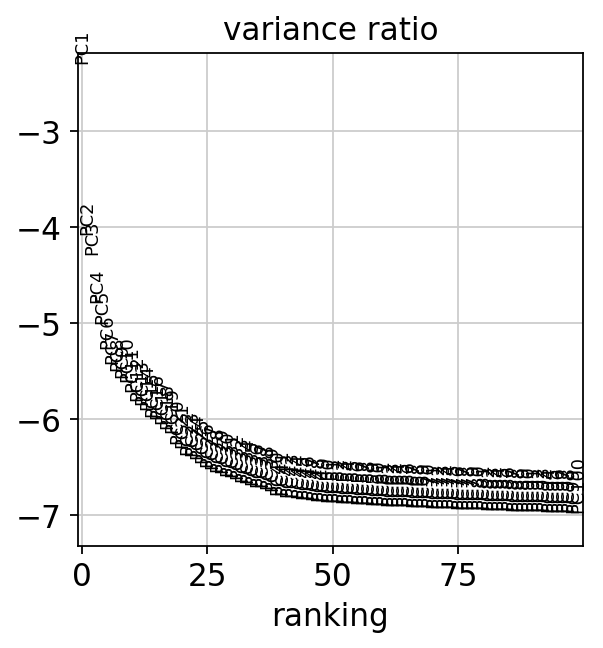

In [48]:
## PCA
sc.tl.pca(adata_combat,  n_comps=100, svd_solver='arpack')
# Pick nPC
sc.pl.pca_variance_ratio(adata_combat, log=True, show=100, n_pcs=100)

In [49]:
#nPC=45
sc.pp.neighbors(adata_combat, n_neighbors=15, n_pcs=45)

computing neighbors
    using 'X_pca' with n_pcs = 45
    finished (0:00:05.67) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


In [50]:
#run tSNE
sc.tl.tsne(adata_combat, n_pcs=45, use_fast_tsne=True, n_jobs=20, perplexity=30)

computing tSNE
    using 'X_pca' with n_pcs = 45
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:01:16.40) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


saving figure to file ./figures/tsne_Batch_Combat.pdf


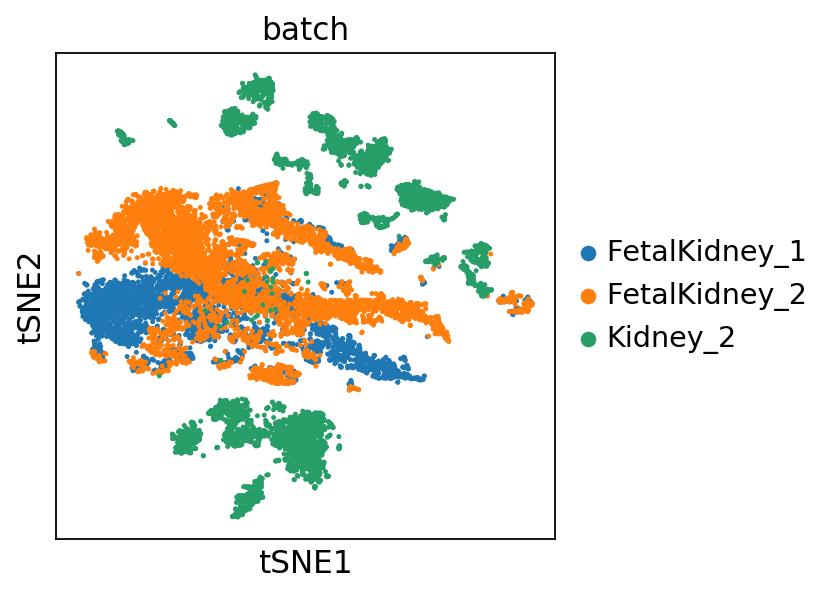

saving figure to file ./figures/tsne_CellType_Combat.pdf


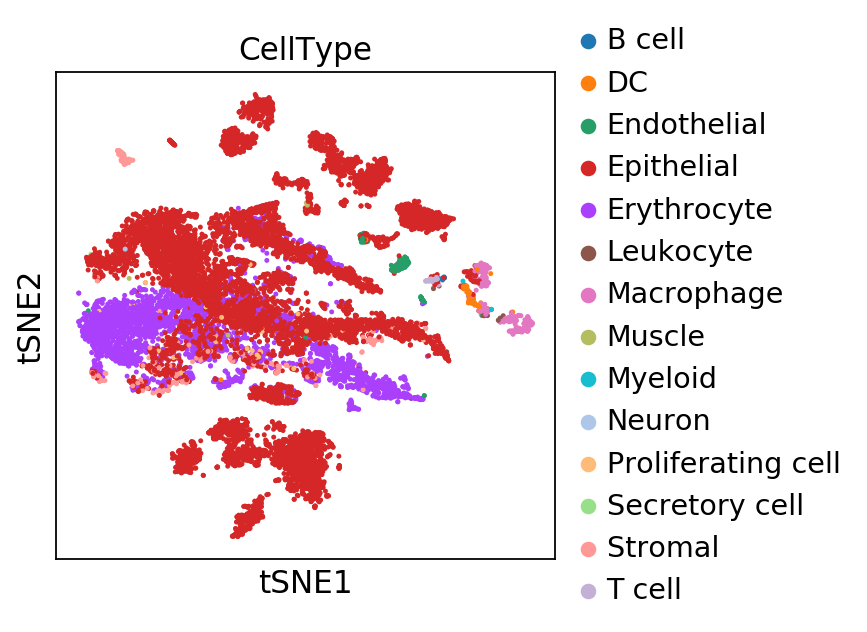

saving figure to file ./figures/tsne_CellType_Combat_ondata.pdf


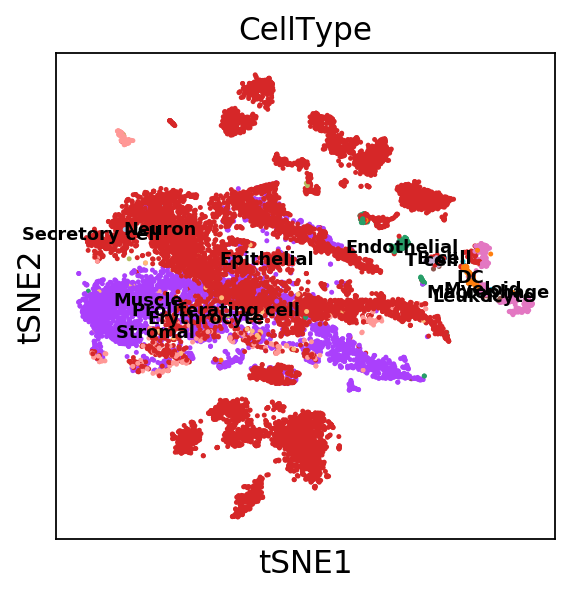

In [51]:
sc.pl.tsne(adata_combat, color=['batch'], size=20, save="_Batch_Combat.pdf")
sc.pl.tsne(adata_combat, color=['CellType'], size=20, save="_CellType_Combat.pdf")
sc.pl.tsne(adata_combat, color=['CellType'], size=20, legend_loc='on data', legend_fontsize=8, save="_CellType_Combat_ondata.pdf")

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:02.18) --> found 19 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
saving figure to file ./figures/tsne_Cluster_Combat.pdf


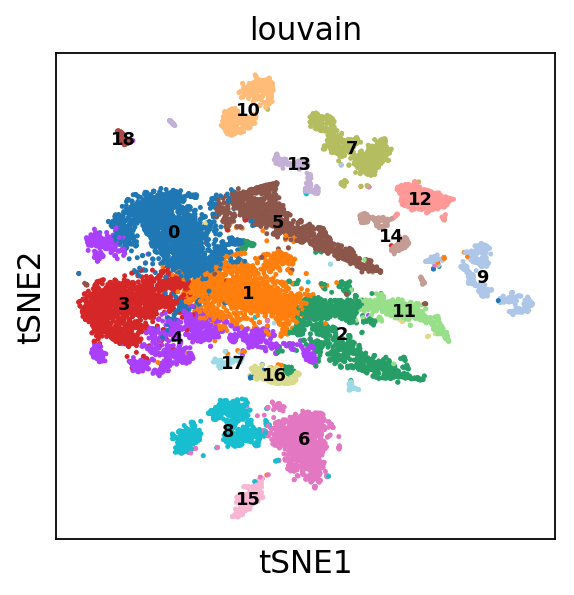

In [52]:
#res=0.6
sc.tl.louvain(adata_combat, resolution=0.6)
sc.pl.tsne(adata_combat, color='louvain', size=20, legend_loc='on data', legend_fontsize=8,save='_Cluster_Combat.pdf')

In [53]:
adata_combat.obs.to_csv("./cluster_Combat.txt", index=False)

In [54]:
import scanorama

In [55]:
adata_scanorama = adata.copy()

In [56]:
adata_list = [adata_scanorama[adata_scanorama.obs['batch'] == i] for i in adata_scanorama.obs['batch'].unique()]

In [57]:
#check
print(adata_list[0].shape)
print(adata_list[0])

(3623, 2237)
View of AnnData object with n_obs × n_vars = 3623 × 2237 
    obs: 'Cell', 'Cluster_id', 'batch', 'P', 'Tissue', 'OldCellType', 'CellType', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'


In [58]:
%%time
intergrated, corrected = scanorama.correct_scanpy(adata_list, return_dimred=True)

Found 2237 genes among all datasets
[[0.         0.67402705 0.00813182]
 [0.         0.         0.34645838]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
CPU times: user 2min 21s, sys: 1min 26s, total: 3min 48s
Wall time: 36.8 s


In [59]:
corrected_merged_dge = corrected[0].concatenate(*corrected[1:])
corrected_merged_dge.obs = adata_scanorama.obs

In [60]:
## scale the data
sc.pp.scale(corrected_merged_dge, max_value=10)

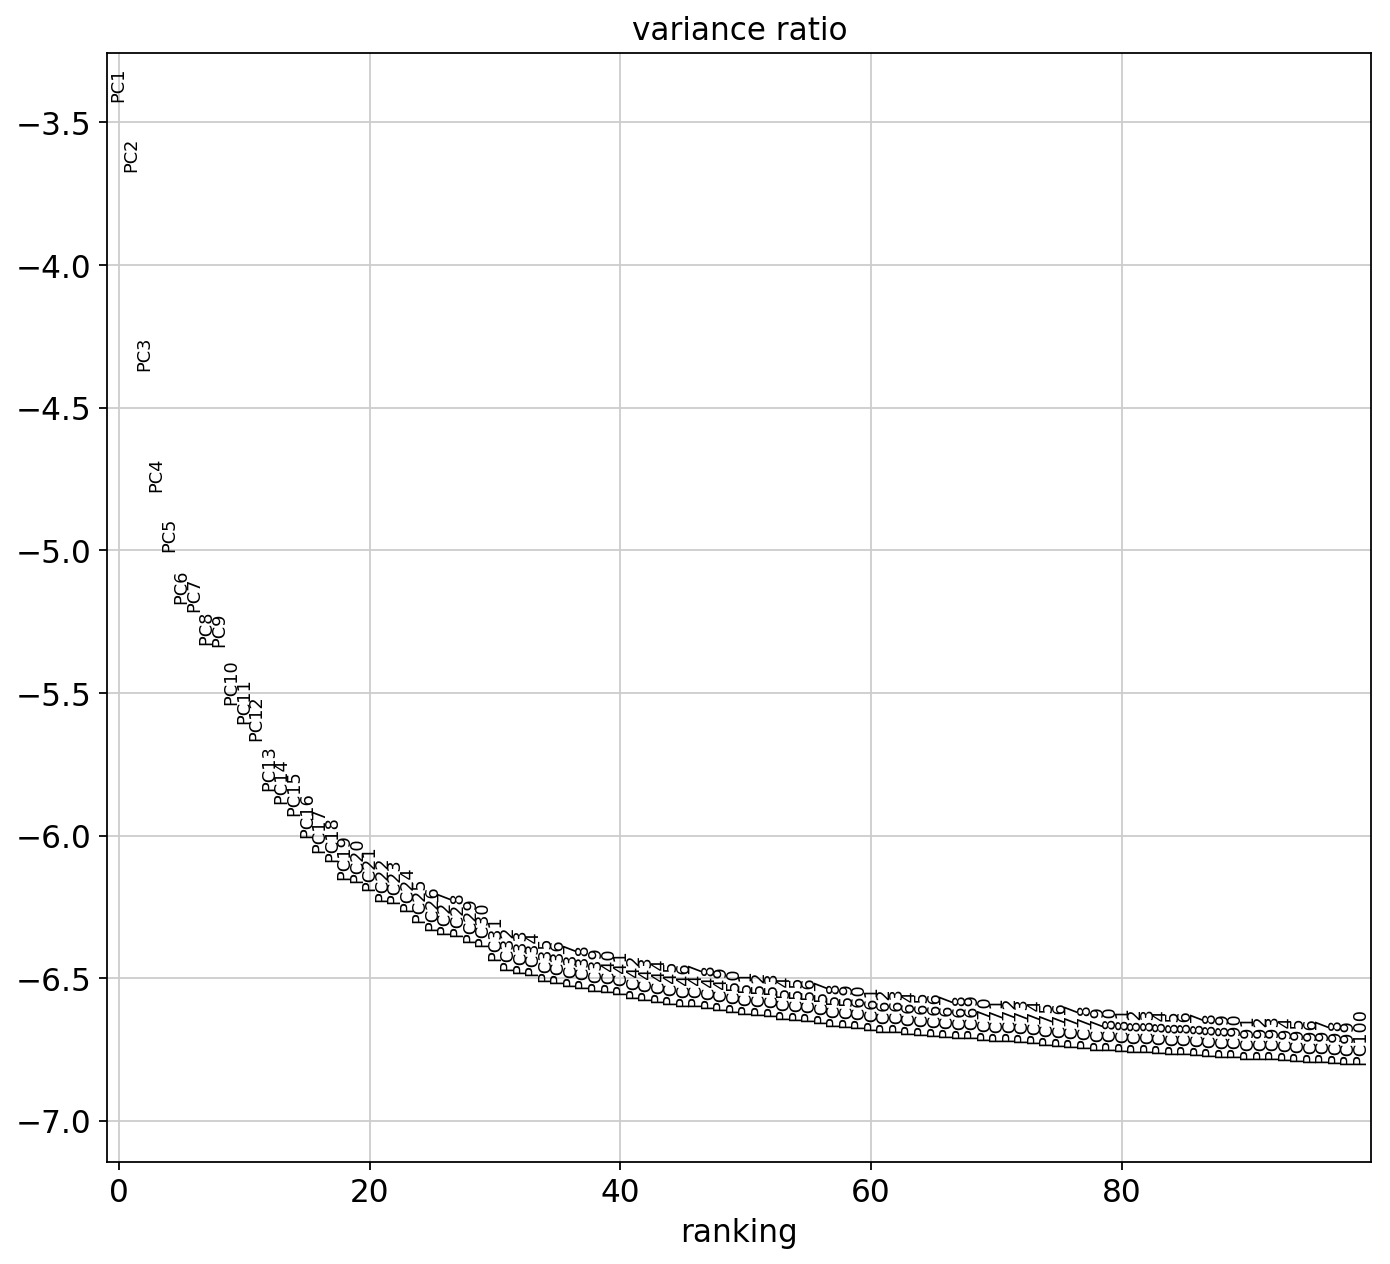

In [61]:
## PCA
sc.tl.pca(corrected_merged_dge, n_comps=100, svd_solver='arpack')
# Pick nPC
sc.pl.pca_variance_ratio(corrected_merged_dge, log=True, show=100, n_pcs=100)

In [62]:
#nPC=45
sc.pp.neighbors(corrected_merged_dge, n_neighbors=15, n_pcs=45)

computing neighbors
    using 'X_pca' with n_pcs = 45
    finished (0:00:05.01) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


In [63]:
#run tSNE
sc.tl.tsne(corrected_merged_dge, n_pcs=45, use_fast_tsne=True, n_jobs=20, perplexity=30)

computing tSNE
    using 'X_pca' with n_pcs = 45
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:01:20.02) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


In [64]:
sc.pl.tsne(corrected_merged_dge, color=['batch'], size=20, save="_Batch_Scanorama.pdf")
sc.pl.tsne(corrected_merged_dge, color=['CellType'], size=20, save="_CellType_Scanorama.pdf")
sc.pl.tsne(corrected_merged_dge, color=['CellType'], size=20, legend_loc='on data', legend_fontsize=8, save="_CellType_Scanoram_ondata.pdf")

saving figure to file ./figures/tsne_Batch_Scanorama.pdf
saving figure to file ./figures/tsne_CellType_Scanorama.pdf
saving figure to file ./figures/tsne_CellType_Scanoram_ondata.pdf


In [65]:
#res=0.6
sc.tl.louvain(corrected_merged_dge, resolution=0.6)
sc.pl.tsne(corrected_merged_dge, color='louvain', size=20, legend_loc='on data', legend_fontsize=8,save='_Cluster_Scanorama.pdf')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:01.59) --> found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
saving figure to file ./figures/tsne_Cluster_Scanorama.pdf


In [66]:
corrected_merged_dge.obs.to_csv("./cluster_Scanorama.txt", index=False)

In [67]:
#corrected_merged_dge=sc.read("adata_scanorama.h5ad")
#corrected_merged_dge

In [68]:
adata_mnn = adata.copy()

In [69]:
%%time
adata_mnn, _, _ = sc.external.pp.mnn_correct(*adata_list)

Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 2: processing batch 1
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 2 of 2: processing batch 2
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...
Done.
CPU times: user 58min 28s, sys: 1min 59s, total: 1h 27s
Wall time: 5min 18s


In [70]:
## scale the data
sc.pp.scale(adata_mnn, max_value=10)

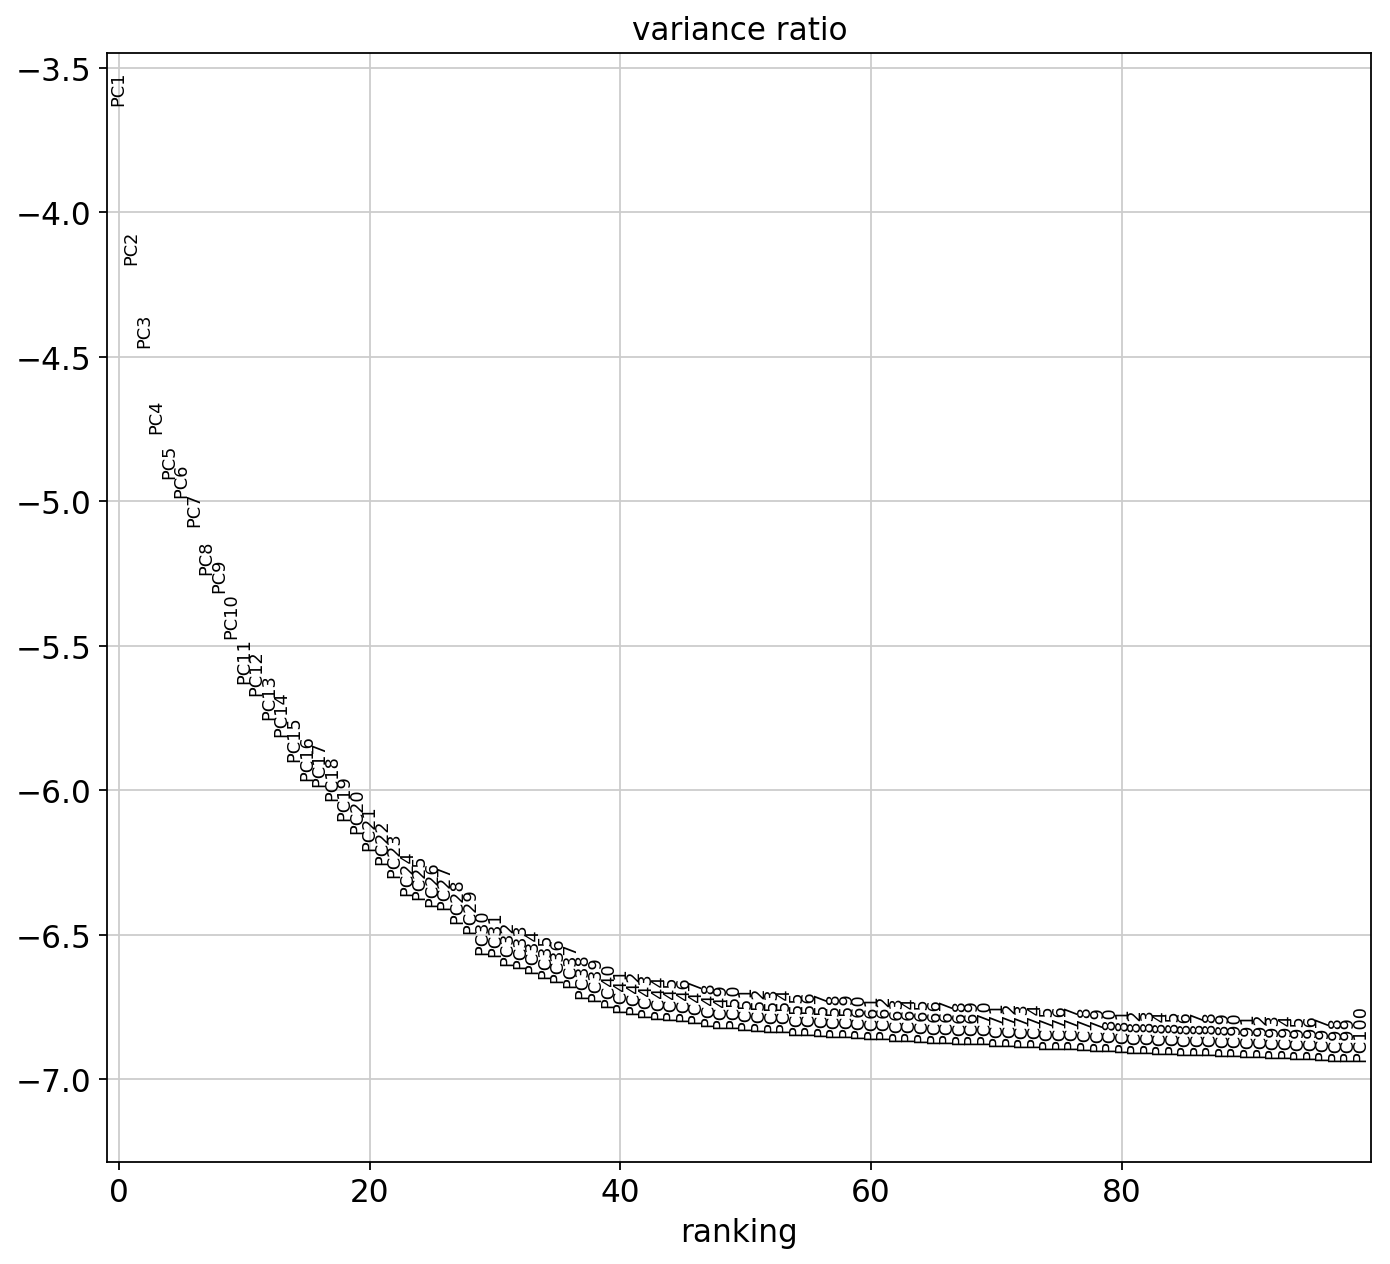

In [71]:
## PCA
sc.tl.pca(adata_mnn, n_comps=100, svd_solver='arpack')
# Pick nPC
sc.pl.pca_variance_ratio(adata_mnn, log=True, show=100, n_pcs=100)

In [72]:
#nPC=45
sc.pp.neighbors(adata_mnn, n_pcs=45, n_neighbors=15)

computing neighbors
    using 'X_pca' with n_pcs = 45
    finished (0:00:04.99) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


In [73]:
sc.tl.tsne(adata_mnn, n_pcs=45, use_fast_tsne=True, n_jobs=20, perplexity=30)

computing tSNE
    using 'X_pca' with n_pcs = 45
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:01:22.22) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


In [74]:
sc.pl.tsne(adata_mnn, color=['batch'], size=20, save="_Batch_mnn.pdf")
sc.pl.tsne(adata_mnn, color=['CellType'], size=20, save="_CellType_mnn.pdf")
sc.pl.tsne(adata_mnn, color=['CellType'], size=20, legend_loc='on data', legend_fontsize=8, save="_CellType_mnn_ondata.pdf")

... storing 'CellType' as categorical
... storing 'OldCellType' as categorical
... storing 'P' as categorical
... storing 'Tissue' as categorical
saving figure to file ./figures/tsne_Batch_mnn.pdf
saving figure to file ./figures/tsne_CellType_mnn.pdf
saving figure to file ./figures/tsne_CellType_mnn_ondata.pdf


In [75]:
#res=0.6
sc.tl.louvain(adata_mnn, resolution=0.6)
sc.pl.tsne(adata_mnn, color='louvain', size=20, legend_loc='on data', legend_fontsize=8,save='_Cluster_mnn.pdf')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:01.53) --> found 16 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
saving figure to file ./figures/tsne_Cluster_mnn.pdf


In [76]:
adata_mnn.obs.to_csv("./cluster_mnn.txt", index=False)

In [77]:
#adata_mnn=sc.read("adata_mnns.h5ad")
#adata_mnn

In [78]:
adata.write("./adata.h5ad")
adata_base.write("./adata_base.h5ad")
adata_combat.write("./adata_combat.h5ad")
adata_reg.write("./adata_reg.h5ad")
corrected_merged_dge.write("./adata_scanorama.h5ad")
adata_mnn.write("./adata_mnns.h5ad")

In [79]:
import glob
fnames = glob.glob("adata_*.h5ad")
fnames

['adata_base.h5ad',
 'adata_combat.h5ad',
 'adata_reg.h5ad',
 'adata_mnns.h5ad',
 'adata_scanorama.h5ad']

In [98]:
for fname in fnames:
    adata = sc.read_h5ad(fname)
    df = pd.DataFrame(adata.X)
    df.index = adata.obs.index
    df.columns = adata.var.index
    df.to_csv(fname.split('.')[0]+'.dge.csv')

In [97]:
adata_base.write("./adata_base.h5ad")